In this notebook, we will construct some general bigram transition matrices.

In [1]:
# General Code for Loading Gutenburg Text
# Load list of fiction
import pickle, gzip
import zipfile

# Get a list of fiction
fiction_dict = pickle.load(gzip.open("fiction_list.gz", 'rb'))
ids = list(fiction_dict.keys())
test_book = fiction_dict[ids[0]]

with zipfile.ZipFile(test_book['path'], 'r') as book_zip:
    # We might want to change this to open the one txt file in the zip
    with book_zip.open('{0}.txt'.format(test_book['id'])) as txtfile:
        text = txtfile.read().decode()
        
print("The book is {0} text characters long".format(len(text)))

The book is 306904 text characters long


In [2]:
text[0:20]

"Project Gutenberg's "

In [3]:
type(text)

str

In [4]:
lowercase = text.lower(); lowercase[0:50]

"project gutenberg's the house on the borderland, b"

Importing the character dictionary we built here - https://github.com/benhoyle/patentdata/blob/spacy/patentdata/models/chardict.py.

Amending the character set to have a reduced number.

In [5]:
import string
import unicodedata


def decompose_character(char):
    """ Attempt to return decomposed version of a character
    as list of normalised."""
    try:
        return [
            chr(int(u, 16))
            for u in unicodedata.decomposition(char).split(" ")
            if u and '<' not in u
            ]
    except:
        return None

# Simplying 

class CharDict:
    """ Class to model mapping between characters and integers. """

    def __init__(self):
        """ Initialise and reverse control characters. """
        # Set character set we will use
        self.character_set = (
            string.ascii_lowercase +
            "! ,.?'"
            )
        # Populate rest of dictionary from character set
        self.reverse_dict = {
            i: c for i, c in enumerate(self.character_set, start=0)
            }
        cs_len = len(self.reverse_dict)
        # Reserve special characters    
        self.reverse_dict[cs_len + 0] = "<OOD>" # Out of dict
        self.reverse_dict[cs_len + 1] = "<CAPITAL>" # Out of dict

        self.vocabulary_size = len(self.reverse_dict)

        self.forward_dict = {
            v: k for k, v in self.reverse_dict.items()
            }

        # Create character cleaning dictionary
        self.char_cleaner = dict()
        self.char_cleaner['”'] = "'"
        self.char_cleaner['“'] = "'"
        self.char_cleaner['\u2003'] = ' '
        self.char_cleaner['\ue89e'] = ' '
        self.char_cleaner['\u2062'] = ' '
        self.char_cleaner['\ue8a0'] = ' '
        self.char_cleaner['−'] = '-'
        self.char_cleaner['—'] = '-'
        self.char_cleaner['′'] = "'"
        self.char_cleaner['‘'] = "'"
        self.char_cleaner['’'] = "'"
        self.char_cleaner['×'] = '*'
        self.char_cleaner['⁄'] = '/'

    def int2char(self, integer):
        """ Convert an integer into a character using the object. """
        return self.reverse_dict[integer]

    def clean_char(character):
        if character in self.char_cleaner.keys():
            return self.char_cleaner[character]
        else:
            return character

    def text2int(self, text):
        """ Convert a block of text into an integer. """

        integer_list = list()
        for character in text:
            # Perform mapping for commonly occuring characters
            if character in self.char_cleaner.keys():
                character = self.char_cleaner[character]

            # If character is in mapping dictionary add int to list
            if character in self.forward_dict.keys():
                integer_list.append(self.forward_dict[character])
            elif character in string.ascii_uppercase:
                # If uppercase
                integer_list.append(self.forward_dict["<CAPITAL>"])
                integer_list.append(self.forward_dict[character.lower()])
            else:
                replacement_chars = decompose_character(character)
                if replacement_chars:
                    integer_list += self.text2int("".join(replacement_chars))
                else:
                    integer_list.append(self.forward_dict["<OOD>"])
        return integer_list

    def intlist2text(self, int_list):
        """ Convert a list of integers back into text. """
        text = str()
        capitalise = False
        for i in int_list:
            char = self.reverse_dict[i]
            if char == "<CAPITAL>":
                capitalise = True
            else:
                if capitalise == True:
                    char = char.upper()
                text += char
                capitalise = False
        return text

    # We need to add a method that returns a one-hot encoding


In [6]:
chardict = CharDict()

In [7]:
chardict.text2int(lowercase[0:20])

[15, 17, 14, 9, 4, 2, 19, 27, 6, 20, 19, 4, 13, 1, 4, 17, 6, 31, 18, 27]

In [8]:
chardict.reverse_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [9]:
integers = chardict.text2int(lowercase)

In [10]:
len(integers)

306904

To determine a bigram transition matrix, we convert each integer into a one-hot representation. Then we create a transition matrix the same length as the keys. Then we simply increment mat[i, j] with i and j as the two consecutive characters.

In [11]:
chardict.vocabulary_size

34

In [12]:
type(integers[9])

int

In [13]:
import numpy as np

In [14]:
# Define transition matrix
num_ints = chardict.vocabulary_size
trans_mat = np.zeros(shape=(num_ints, num_ints))
# For each pair of characters
for char_1, char_2 in zip(integers[0:-1], integers[1:]):
    trans_mat[char_1, char_2] += 1

In [15]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


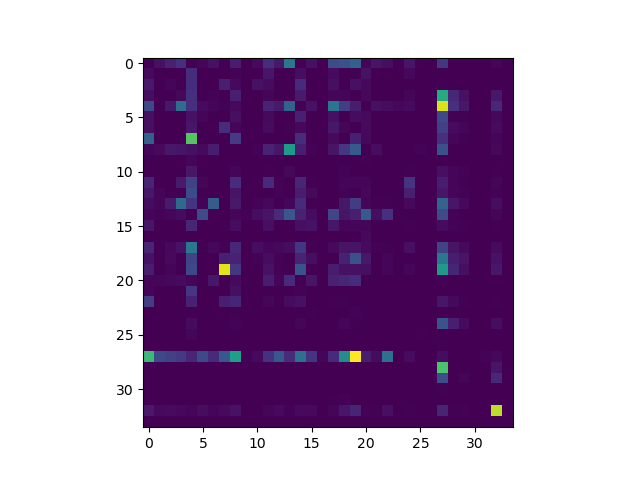

In [16]:
%matplotlib notebook
plt.imshow(trans_mat)

This shows we can probably ditch many of the characters initially.

We can maybe keep: "!,? \<space\>.

In [17]:
chardict.character_set

"abcdefghijklmnopqrstuvwxyz! ,.?'"

In [18]:
trans_mat/trans_mat.max()

array([[2.36658384e-04, 4.59117264e-02, 9.14684653e-02, ...,
        1.18329192e-04, 1.36078571e-02, 0.00000000e+00],
       [2.43758135e-02, 3.78653414e-03, 2.36658384e-04, ...,
        0.00000000e+00, 3.54987575e-04, 0.00000000e+00],
       [6.89859188e-02, 0.00000000e+00, 1.36078571e-02, ...,
        0.00000000e+00, 1.30162111e-03, 0.00000000e+00],
       ...,
       [3.54987575e-04, 2.36658384e-04, 8.28304343e-04, ...,
        0.00000000e+00, 8.28304343e-04, 0.00000000e+00],
       [6.69743226e-02, 2.39024967e-02, 2.79256893e-02, ...,
        2.01159626e-03, 8.98710212e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [19]:
integer_mat = ((trans_mat/trans_mat.max())*255).astype(np.uint8)

<IPython.core.display.Javascript object>


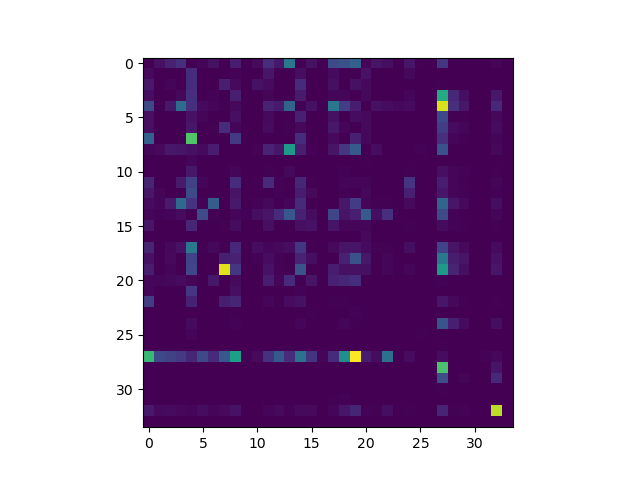

In [20]:
plt.imshow(integer_mat)

In [21]:
np.set_printoptions(threshold=np.inf)
integer_mat

array([[  0,  11,  23,  35,   0,   4,  11,   0,  19,   0,   6,  32,  16,
        101,   0,  11,   0,  59,  63,  79,   3,  13,   9,   0,  14,   1,
          0,  41,   0,   0,   0,   0,   3,   0],
       [  6,   0,   0,   0,  33,   0,   0,   0,   2,   0,   0,  15,   0,
          0,   9,   0,   0,   7,   1,   1,  12,   0,   0,   0,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,   3,   0,  33,   0,   0,  21,   6,   0,  11,   7,   0,
          0,  30,   0,   0,  10,   0,  11,   5,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   0,   0],
       [  9,   0,   0,   5,  34,   0,   2,   0,  21,   0,   0,   4,   0,
          0,  18,   0,   0,   4,   4,   0,   5,   0,   0,   0,   3,   0,
          0, 157,  28,  10,   0,   0,  16,   0],
       [ 56,   1,  16,  90,  34,   7,   3,   1,   6,   0,   0,  25,  18,
         82,   1,  11,   0, 100,  46,  20,   0,  11,   8,   5,   7,   0,
          0, 240,  34,  16,   0,   0,  29,   0],
       [ 10,   0,   0,   

In [22]:
integer_mat_16 = ((trans_mat/trans_mat.max())*(2**16)).astype(np.uint16)

In [23]:
print(integer_mat_16)

[[   15  3008  5994  9135    93  1248  2869   155  4970     0  1698  8476
   4288 26149   255  3055     0 15245 16401 20395   891  3543  2427    85
   3714   480     7 10608   100    93     7     7   891     0]
 [ 1597   248    15    38  8545     0     0     7   566    69     0  4016
     31    15  2473     0     0  1822   302   310  3264     7     0     0
   1318     0     0   116    31    77     0     0    23     0]
 [ 4521     0   891     0  8483     0     0  5397  1550     0  2977  2047
      0     0  7739     0    15  2644     0  3055  1450     0     0     0
    131     0     0   418    23    15     0     0    85     0]
 [ 2535     0    46  1302  8972    62   535     0  5606    15     7  1046
     23   124  4815     0     0  1147  1039    54  1326    62   131     0
    860     0    62 40363  7429  2822    31    54  4241     0]
 [14602   387  4218 23318  8902  2000   930   426  1613     0   116  6459
   4769 21124   341  3078   170 25846 11857  5164    31  3024  2062  1519
   1861 

<IPython.core.display.Javascript object>


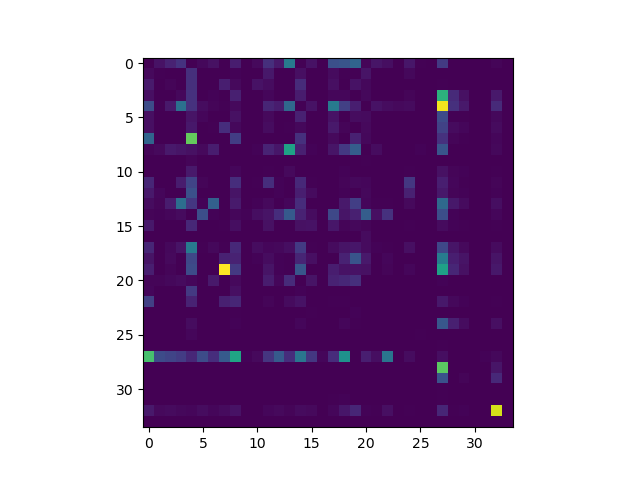

In [24]:
plt.imshow(integer_mat_16)

# Process All Books

Now let's loop through all the books and build a 16 bit transition matrix.

In [25]:
# Define transition matrix
num_ints = chardict.vocabulary_size
trans_mat = np.zeros(shape=(num_ints, num_ints))

for book_id in ids:
    test_book = fiction_dict[book_id]

    try:
        # Get text
        with zipfile.ZipFile(test_book['path'], 'r') as book_zip:
            # We might want to change this to open the one txt file in the zip
            with book_zip.open('{0}.txt'.format(test_book['id'])) as txtfile:
                text = txtfile.read().decode()
                
        temp_trans_mat = np.zeros(shape=(num_ints, num_ints))
        integers = chardict.text2int(text)
        # For each pair of characters
        for char_1, char_2 in zip(integers[0:-1], integers[1:]):
            temp_trans_mat[char_1, char_2] += 1
            
        integer_trans_mat = ((temp_trans_mat/temp_trans_mat.max())*(2**16)).astype(np.uint16)
        
        # Average
        trans_mat = trans_mat//2 + integer_trans_mat//2
    except Exception as e: 
        print(f"An error occurred with book {test_book['title']}")
        print(f"Error: {e}")

An error occurred with book Carmilla
Error: 'path'
An error occurred with book The Secret of the Tower
Error: 'utf-8' codec can't decode byte 0xe9 in position 230719: invalid continuation byte
An error occurred with book Aunt Jane's Nieces on Vacation
Error: 'utf-8' codec can't decode byte 0xe9 in position 280951: invalid continuation byte
An error occurred with book The Postmaster's Daughter
Error: 'path'
An error occurred with book The First Men in the Moon
Error: 'path'
An error occurred with book Dracula's Guest
Error: 'path'
An error occurred with book The Water-Babies
Error: 'path'
An error occurred with book The Diary of a Nobody
Error: 'path'
An error occurred with book The Professor
Error: 'utf-8' codec can't decode byte 0xa0 in position 779: invalid start byte
An error occurred with book The Rover Boys at College; Or, The Right Road and the Wrong
Error: 'utf-8' codec can't decode byte 0xeb in position 39427: invalid continuation byte
An error occurred with book An Antarctic M

An error occurred with book In the Clutch of the War-God
Error: 'utf-8' codec can't decode byte 0xb0 in position 28983: invalid start byte
An error occurred with book Scorched Earth: A Future History of Planet Earth
Error: 'utf-8' codec can't decode byte 0xe9 in position 19092: invalid continuation byte
An error occurred with book Les Misérables
Error: 'path'
An error occurred with book Andrew the Glad
Error: 'utf-8' codec can't decode byte 0xe9 in position 26653: invalid continuation byte
An error occurred with book When the World Shook: Being an Account of the Great Adventure of Bastin, Bickley and Arbuthnot
Error: 'path'
An error occurred with book Mardi: and A Voyage Thither, Vol. I
Error: 'utf-8' codec can't decode byte 0xe9 in position 138343: invalid continuation byte
An error occurred with book The Adventure Club Afloat
Error: 'utf-8' codec can't decode byte 0xea in position 228414: invalid continuation byte
An error occurred with book The Indiscretion of the Duchess: Being a S

An error occurred with book Armadale
Error: 'path'
An error occurred with book Penguin Island
Error: 'path'
An error occurred with book In the Year 2889
Error: 'path'
An error occurred with book Dorothy and the Wizard in Oz
Error: 'utf-8' codec can't decode byte 0x97 in position 3139: invalid start byte
An error occurred with book The Marvelous Land of Oz
Error: 'path'
An error occurred with book Little Wizard Stories of Oz
Error: 'path'
An error occurred with book A Christmas Carol
Error: 'path'
An error occurred with book A Connecticut Yankee in King Arthur's Court
Error: 'path'
An error occurred with book A Journey to the Center of the Earth
Error: 'path'
An error occurred with book A Little Princess
Error: 'path'
An error occurred with book A Princess of Mars
Error: 'path'
An error occurred with book The Adventures of Pinocchio
Error: 'path'
An error occurred with book The Yellow Wallpaper
Error: 'path'
An error occurred with book Alice's Adventures in Wonderland
Error: 'path'
An e

An error occurred with book "Captains Courageous": A Story of the Grand Banks
Error: 'path'
An error occurred with book Oldtown Fireside Stories
Error: 'path'
An error occurred with book Tom Swift and the Visitor From Planet X
Error: 'path'
An error occurred with book The Wind in the Willows
Error: 'path'
An error occurred with book The Wind in the Willows
Error: 'path'
An error occurred with book Alexander's Bridge
Error: 'path'
An error occurred with book The Camp of the Dog
Error: 'path'
An error occurred with book The Fortieth Door
Error: 'path'
An error occurred with book The Tale of Timothy Turtle
Error: 'path'
An error occurred with book The Story of a Stuffed Elephant
Error: 'path'
An error occurred with book The Prisoner of Zenda
Error: 'path'
An error occurred with book The Price of Love
Error: 'path'
An error occurred with book The Parenticide Club
Error: 'path'
An error occurred with book The King in Yellow, Part 2
Error: 'path'
An error occurred with book The Gift of the M

An error occurred with book War and Peace
Error: 'path'
An error occurred with book Queen Sheba's Ring
Error: 'path'
An error occurred with book The Pigeon Pie
Error: 'path'
An error occurred with book Notre-Dame de Paris
Error: 'path'
An error occurred with book The Story of Doctor Dolittle
Error: 'path'
An error occurred with book The Adventures of Tom Sawyer
Error: 'path'
An error occurred with book The Dog Crusoe and His Master
Error: 'path'
An error occurred with book A Girl of the Limberlost
Error: 'path'
An error occurred with book The Golden Road
Error: 'path'
An error occurred with book Just So Stories
Error: 'path'
An error occurred with book Candide
Error: 'path'
An error occurred with book The Picture of Dorian Gray
Error: 'path'
An error occurred with book The Invisible Man: A Grotesque Romance
Error: 'path'
An error occurred with book The Strange Case of Dr Jekyll & Mr Hyde
Error: 'path'
An error occurred with book The Prince and the Pauper
Error: 'path'
An error occurred

An error occurred with book Spawn of the Comet
Error: 'utf-8' codec can't decode byte 0x93 in position 711: invalid start byte
An error occurred with book With the Night Mail: A Story of 2000 A.D.: (Together with extracts from the comtemporary magazine in which it appeared)
Error: 'utf-8' codec can't decode byte 0xb6 in position 79418: invalid start byte
An error occurred with book The Golden Age
Error: 'path'
An error occurred with book Howards End
Error: 'path'
An error occurred with book The Captain of the Polestar, and Other Tales
Error: 'utf-8' codec can't decode byte 0xfc in position 147094: invalid start byte
An error occurred with book The Midnight Queen
Error: 'utf-8' codec can't decode byte 0xe9 in position 282415: invalid continuation byte
An error occurred with book Is He Popenjoy?
Error: 'utf-8' codec can't decode byte 0xa3 in position 123202: invalid start byte
An error occurred with book The Romantic Adventures of a Milkmaid
Error: 'path'
An error occurred with book Walt

An error occurred with book Mashi, and Other Stories
Error: 'path'
An error occurred with book My Actor-Husband: A true story of American stage life
Error: 'utf-8' codec can't decode byte 0xb6 in position 359463: invalid start byte
An error occurred with book The Yellow Rose
Error: 'utf-8' codec can't decode byte 0xf3 in position 50: invalid continuation byte
An error occurred with book The Children of Alsace (Les Oberlés)
Error: 'path'
An error occurred with book Jo's Boys
Error: 'path'
An error occurred with book Abbé Aubain and Mosaics
Error: 'path'
An error occurred with book Diary of a U-Boat Commander
Error: 'path'
An error occurred with book A Duet, with an Occasional Chorus
Error: 'path'
An error occurred with book Anna of the Five Towns
Error: 'path'
An error occurred with book La Mere Bauche: From Tales of All Countries
Error: 'path'
An error occurred with book The Sword of Honor; or, The Foundation of the French Republic: A Tale of The French Revolution
Error: 'utf-8' codec 

An error occurred with book The Leavenworth Case
Error: 'path'
An error occurred with book The Bath Keepers; Or, Paris in Those Days, v.2: (Novels of Paul de Kock Volume VIII)
Error: 'path'
An error occurred with book The Freebooters: A Story of the Texan War
Error: 'path'
An error occurred with book Gaston de Latour; an unfinished romance
Error: 'path'
An error occurred with book Frederick the Great and His Court
Error: 'utf-8' codec can't decode byte 0xfc in position 62: invalid start byte
An error occurred with book Off to Sea: The Adventures of Jovial Jack Junker on his Road to Fame
Error: 'path'
An error occurred with book The White House (Novels of Paul de Kock Volume XII)
Error: 'path'
An error occurred with book Meg, of Valencia
Error: 'path'
An error occurred with book My Neighbor Raymond (Novels of Paul de Kock Volume XI)
Error: 'path'
An error occurred with book The Fishguard Invasion by the French in 1797
Error: 'path'
An error occurred with book The Sicilian Bandit: From t

An error occurred with book Kate Vernon: A Tale. Vol. 1 (of 3)
Error: 'path'
An error occurred with book Boscobel; or, the royal oak: A tale of the year 1651
Error: 'path'
An error occurred with book The Prairie-Bird
Error: 'path'
An error occurred with book The Boy Scouts Afoot in France; or, With the Red Cross Corps at the Marne
Error: 'path'
An error occurred with book Mrs. Darrell
Error: 'path'
An error occurred with book The White Shield
Error: 'path'
An error occurred with book John Brown: Confessions of a New Army Cadet
Error: 'path'
An error occurred with book Jack the Young Cowboy: An Eastern Boy's Experiance on a Western Round-up
Error: 'path'
An error occurred with book "Short Sixes": Stories to be Read While the Candle Burns
Error: 'path'
An error occurred with book The Motor Boys After a Fortune; or, The Hut on Snake Island
Error: 'path'
An error occurred with book Vine and Olive; Or, Young America in Spain and Portugal: A Story of Travel and Adventure
Error: 'path'
An err

An error occurred with book Brought Forward
Error: 'path'
An error occurred with book Fathers and Sons
Error: 'path'
An error occurred with book The Admiral: A Romance of Nelson in the Year of the Nile
Error: 'path'
An error occurred with book The Minister's Wooing
Error: 'path'
An error occurred with book The Talk of the Town, Volume 1 (of 2)
Error: 'path'
An error occurred with book The Talk of the Town, Volume 2 (of 2)
Error: 'path'
An error occurred with book Frank Armstrong at College
Error: 'path'
An error occurred with book Jack Tier; Or, The Florida Reef
Error: 'path'
An error occurred with book Hildebrand; or, The Days of Queen Elizabeth, An Historic Romance, Vol. 1 of 3
Error: 'path'
An error occurred with book For the Honor of the School: A Story of School Life and Interscholastic Sport
Error: 'path'
An error occurred with book Motor Matt's Hard Luck; or, The Balloon-House Plot
Error: 'path'
An error occurred with book Trafalgar: A Tale
Error: 'path'
An error occurred with b

An error occurred with book Brenda's Cousin at Radcliffe: A Story for Girls
Error: 'path'
An error occurred with book Diane of Ville Marie: A Romance of French Canada
Error: 'path'
An error occurred with book Les Misérables, v. 1/5: Fantine
Error: 'path'
An error occurred with book Les Misérables, v. 2/5: Cosette
Error: 'path'
An error occurred with book Les Misérables, v. 3/5: Marius
Error: 'path'
An error occurred with book Les Misérables, v. 4/5: The Idyll and the Epic
Error: 'path'
An error occurred with book Les Misérables, v. 5/5: Jean Valjean
Error: 'path'
An error occurred with book The Missionary: An Indian Tale; vol. I
Error: 'path'
An error occurred with book The Missionary: An Indian Tale; vol. II
Error: 'path'
An error occurred with book The Missionary: An Indian Tale; vol. III
Error: 'path'
An error occurred with book Captain of the Crew
Error: 'path'
An error occurred with book Who Ate the Pink Sweetmeat? And Other Christmas Stories
Error: 'path'
An error occurred with b

An error occurred with book The Three Bears of Porcupine Ridge
Error: 'path'
An error occurred with book Arabella Stuart: A Romance from English History
Error: 'path'
An error occurred with book The Stories Polly Pepper Told to the Five Little Peppers in the Little Brown House
Error: 'path'
An error occurred with book The Old Dominion
Error: 'path'
An error occurred with book The Little Ball O' Fire; or, the Life and Adventures of John Marston Hall: The Works of G. P. R. James, Vol. XV.
Error: 'path'
An error occurred with book My Friend Pasquale, and Other Stories
Error: 'path'
An error occurred with book Under Orders: The story of a young reporter
Error: 'path'
An error occurred with book The Scouts of Seal Island
Error: 'path'
An error occurred with book God's Playthings
Error: 'path'
An error occurred with book Jimmy Boy
Error: 'path'
An error occurred with book Kit and Kitty: A Story of West Middlesex
Error: 'path'
An error occurred with book First Lensman
Error: 'path'
An error o

An error occurred with book John Gutenberg, First Master Printer: His Acts and Most Remarkable Discourses and his Death
Error: 'path'
An error occurred with book The Hand-Made Gentleman: A Tale of the Battles of Peace
Error: 'path'
An error occurred with book Under Sentence of Death; Or, a Criminal's Last Hours
Error: 'path'
An error occurred with book The Trail of the Green Doll: A Judy Bolton Mystery
Error: 'path'
An error occurred with book The Wailing Asteroid
Error: 'path'
An error occurred with book A Dog of Flanders, The Nürnberg Stove, and Other Stories
Error: 'path'
An error occurred with book Wyllard's Weird: A Novel
Error: 'path'
An error occurred with book The Forgery; or, Best Intentions.
Error: 'path'
An error occurred with book Romantic legends of Spain
Error: 'path'
An error occurred with book The Motor Boys on the Pacific; Or, the Young Derelict Hunters
Error: 'utf-8' codec can't decode byte 0xf1 in position 87726: invalid continuation byte
An error occurred with book 

An error occurred with book The Long Journey
Error: 'path'
An error occurred with book Two Little Pilgrims' Progress: A Story of the City Beautiful
Error: 'path'
An error occurred with book The Young Ship-Builders of Elm Island
Error: 'path'
An error occurred with book The Three Miss Kings: An Australian Story
Error: 'path'
An error occurred with book Notre Coeur; or, A Woman's Pastime: A Novel
Error: 'path'
An error occurred with book Far-away Stories
Error: 'path'
An error occurred with book Darnley; or, The Field of the Cloth of Gold
Error: 'path'
An error occurred with book Abner Daniel: A Novel
Error: 'path'
An error occurred with book Back to Life
Error: 'path'
An error occurred with book The Raft
Error: 'path'
An error occurred with book The Vanishing Point
Error: 'path'
An error occurred with book Mr. Wayt's Wife's Sister
Error: 'path'
An error occurred with book The Sack of Monte Carlo: An Adventure of To-day
Error: 'path'
An error occurred with book Gowrie; or, the King's Plo

An error occurred with book The Convict: A Tale
Error: 'path'
An error occurred with book The Fire and the Sword
Error: 'path'
An error occurred with book The Man in Black: An Historical Novel of the Days of Queen Anne
Error: 'path'
An error occurred with book Inside Earth
Error: 'path'
An error occurred with book The Web of Time
Error: 'path'
An error occurred with book Teddy Bears
Error: 'path'
An error occurred with book Babes in the Bush
Error: 'path'
An error occurred with book Princess Badoura: A tale from the Arabian Nights
Error: 'path'
An error occurred with book Robert Helmont: Diary of a Recluse, 1870-1871
Error: 'path'
An error occurred with book The Pride of Jennico: Being a Memoir of Captain Basil Jennico
Error: 'path'
An error occurred with book Morley Ernstein; or, the Tenants of the Heart
Error: 'path'
An error occurred with book The Cool War
Error: 'path'
An error occurred with book The Last of the Mortimers: A Story in Two Voices
Error: 'path'
An error occurred with 

An error occurred with book The Jessamy Bride
Error: 'path'
An error occurred with book The Manager of the B. & A.: A Novel
Error: 'path'
An error occurred with book A Man: His Mark. A Romance: Second Edition
Error: 'path'
An error occurred with book The Man of Last Resort; Or, The Clients of Randolph Mason
Error: 'path'
An error occurred with book The Strange Schemes of Randolph Mason
Error: 'path'
An error occurred with book Tales from a Rolltop Desk
Error: 'path'
An error occurred with book The Other World
Error: 'path'
An error occurred with book Pawned
Error: 'path'
An error occurred with book The Last Penny
Error: 'path'
An error occurred with book The Life and Adventures of Peter Wilkins, Complete (Volumes 1 and 2)
Error: 'path'
An error occurred with book The Life and Adventures of Peter Wilkins, Volume 2 (of 2)
Error: 'path'
An error occurred with book According to Plato
Error: 'path'
An error occurred with book The Plunderers: A Novel
Error: 'path'
An error occurred with book

An error occurred with book Arminell: A Social Romance, Vol. 1
Error: 'path'
An error occurred with book Tubal Cain
Error: 'path'
An error occurred with book The Unbidden Guest
Error: 'path'
An error occurred with book The Hand of the Mighty, and Other Stories
Error: 'path'
An error occurred with book Arminell: A Social Romance, Vol. 2
Error: 'path'
An error occurred with book Arminell: A Social Romance, Vol. 3
Error: 'path'
An error occurred with book Stories of a Governess
Error: 'path'
An error occurred with book The Cuckoo in the Nest, v. 1/2
Error: 'path'
An error occurred with book Harry Harding—Messenger "45"
Error: 'path'
An error occurred with book Honor Bright: A Story for Girls
Error: 'path'
An error occurred with book Cupid of Campion
Error: 'path'
An error occurred with book Clash of Arms: A Romance
Error: 'path'
An error occurred with book The Gunroom
Error: 'path'
An error occurred with book Miss Fairfax of Virginia: A Romance of Love and Adventure Under the Palmettos
Er

An error occurred with book Marjorie Dean, Marvelous Manager
Error: 'path'
An error occurred with book The House of Cariboo, and Other Tales from Arcadia
Error: 'path'
An error occurred with book Basil and Annette: A Novel
Error: 'path'
An error occurred with book The Golden Age
Error: 'path'
An error occurred with book The Boy Apprenticed to an Enchanter
Error: 'path'
An error occurred with book The Mystery of M. Felix
Error: 'path'
An error occurred with book Murder at Large
Error: 'path'
An error occurred with book Atom Mystery [Young Atom Detective]
Error: 'path'
An error occurred with book The Brighton Boys at Chateau-Thierry
Error: 'path'
An error occurred with book The Child of the Moat: A Story for Girls. 1557 A.D.
Error: 'path'
An error occurred with book A Fair Jewess
Error: 'path'
An error occurred with book The Boy Inventor's Wireless Triumph
Error: 'path'
An error occurred with book The Novel on the Tram
Error: 'path'
An error occurred with book The Motor Boys in the Army;

An error occurred with book A Gentleman of Courage: A Novel of the Wilderness
Error: 'path'
An error occurred with book Bobbie, General Manager: A Novel
Error: 'path'
An error occurred with book The Merman and the Figure-Head
Error: 'path'
An error occurred with book Nostalgia
Error: 'path'
An error occurred with book The Woman & the Priest
Error: 'path'
An error occurred with book Sister Gertrude: A Tale of the West Riding
Error: 'path'
An error occurred with book Baree, Son of Kazan
Error: 'path'
An error occurred with book Frank Reade, Jr., and His New Steam Man; or, the Young Inventor's Trip to the Far West: Frank Reade Library Vol. I
Error: 'path'
An error occurred with book The Sins of the Cities of the Plain; or, The Recollections of a Mary-Ann: with Short Essays on Sodomy and Tribadism
Error: 'path'
An error occurred with book Annie Laurie and Azalea
Error: 'path'
An error occurred with book Right Half Hollins
Error: 'path'
An error occurred with book Marjorie Dean Macy's Hamil

An error occurred with book The Rapin
Error: 'path'
An error occurred with book Cardinal Pole; Or, The Days of Philip and Mary: An Historical Romance
Error: 'path'
An error occurred with book Symzonia: Voyage of Discovery
Error: 'path'
An error occurred with book More "Short Sixes"
Error: 'path'
An error occurred with book The Dreadnought Boys in Home Waters
Error: 'path'
An error occurred with book The Athelings; or, the Three Gifts. Vol. 1/3
Error: 'path'
An error occurred with book Phoebe Daring: A Story for Young Folk
Error: 'path'
An error occurred with book Boy Scouts at Crater Lake: A Story of Crater Lake National Park and the High Cascades
Error: 'path'
An error occurred with book Daughters of Destiny
Error: 'path'
An error occurred with book The Silent Battle
Error: 'path'
An error occurred with book Young Stowaways in Space
Error: 'path'
An error occurred with book Jane Austen and Her Country-house Comedy
Error: 'path'
An error occurred with book An Old Man's Darling
Error: '

An error occurred with book How a Farthing Made a Fortune; or "Honesty is the best policy"
Error: 'path'
An error occurred with book The S. P. Mystery
Error: 'path'
An error occurred with book The Brighton Boys in Transatlantic Flight
Error: 'path'
An error occurred with book The Yellow Holly
Error: 'path'
An error occurred with book March Hares
Error: 'path'
An error occurred with book Seth's Brother's Wife: A Study of Life in the Greater New York
Error: 'path'
An error occurred with book Gloria Mundi
Error: 'path'
An error occurred with book The Brown Brethren
Error: 'path'
An error occurred with book The Beadle Collection of Dime Novels: Given to the New York Public Library By Dr. Frank P. O'Brien
Error: 'path'
An error occurred with book Squib and His Friends
Error: 'path'
An error occurred with book Uncle Wiggily's Fortune
Error: 'path'
An error occurred with book The Yale Cup
Error: 'path'
An error occurred with book Mark Manning's Mission: The Story of a Shoe Factory Boy
Error: 

An error occurred with book Storm in a Teacup
Error: 'path'
An error occurred with book Slaves of Freedom
Error: 'path'
An error occurred with book The Black Lion Inn
Error: 'path'
An error occurred with book Kotto: Being Japanese Curios, with Sundry Cobwebs
Error: 'path'
An error occurred with book Lucian the dreamer
Error: 'path'
An error occurred with book Nequa; or, The Problem of the Ages
Error: 'path'
An error occurred with book The Water-Finders
Error: 'path'
An error occurred with book Lady Jim of Curzon Street: A Novel
Error: 'path'
An error occurred with book The Silver Bullet
Error: 'path'
An error occurred with book Sea Scouts All: How the "Olivette" was won
Error: 'path'
An error occurred with book The Law of the Bolo
Error: 'path'
An error occurred with book The Story of Viteau
Error: 'path'
An error occurred with book The Aeroplane Express; or, The Boy Aeronaut's Grit
Error: 'path'
An error occurred with book Mightier than the Sword
Error: 'path'
An error occurred with b

An error occurred with book The White Dove
Error: 'path'
An error occurred with book The Demagogue and Lady Phayre
Error: 'path'
An error occurred with book Idols
Error: 'path'
An error occurred with book The Black Barque: A Tales of the Pirate Slave-Ship Gentle Hand on Her Last African Cruise
Error: 'path'
An error occurred with book Jan of the Windmill: A Story of the Plains
Error: 'path'
An error occurred with book The Romance of the Harem
Error: 'path'
An error occurred with book Inside the Lines
Error: 'path'
An error occurred with book The Story of Duciehurst: A Tale of the Mississippi
Error: 'path'
An error occurred with book The Young Circus Rider; or, the Mystery of Robert Rudd
Error: 'path'
An error occurred with book Lost in the Atlantic Valley; Or, Frank Reade, Jr., and His Wonder, the "Dart"
Error: 'path'
An error occurred with book From Zone to Zone: Or, The Wonderful Trip of Frank Reade, Jr., with His Latest Air-Ship
Error: 'path'
An error occurred with book Love Insuran

An error occurred with book The Rush for the Spoil (La Curée): A Realistic Novel
Error: 'path'
An error occurred with book Head of the Lower School
Error: 'path'
An error occurred with book Harry Coverdale's Courtship, and All That Came of It
Error: 'path'
An error occurred with book The Fortunes of the Colville Family; or, A Cloud with its Silver Lining
Error: 'path'
An error occurred with book Lewis Arundel; Or, The Railroad Of Life
Error: 'path'
An error occurred with book Frank Hunter's Peril
Error: 'path'
An error occurred with book A Son of the Gods, and A Horseman in the Sky
Error: 'path'
An error occurred with book Ruby Roland, the Girl Spy; or, Simon Kenton's Protege
Error: 'path'
An error occurred with book Johnny Nelson: How a one-time pupil of Hopalong Cassidy of the famous Bar-20 ranch in the Pecos Valley performed an act of knight-errantry and what came of it
Error: 'path'
An error occurred with book Two Little Women and Treasure House
Error: 'path'
An error occurred with

An error occurred with book The heritage of unrest
Error: 'path'
An error occurred with book The Monomaniac (La bête humaine)
Error: 'path'
An error occurred with book Prince Rupert, the Buccaneer
Error: 'path'
An error occurred with book The Pool of Stars
Error: 'path'
An error occurred with book Stavrogin's Confession and The Plan of The Life of a Great Sinner: With Introductory and Explanatory Notes
Error: 'path'
An error occurred with book Winning His Wings: A Story of the R.A.F.
Error: 'path'
An error occurred with book The Corner House
Error: 'path'
An error occurred with book Autobiography of a Child
Error: 'path'
An error occurred with book A Strange World: A Novel. Volume 1 (of 3)
Error: 'path'
An error occurred with book A Strange World: A Novel. Volume 3 (of 3)
Error: 'path'
An error occurred with book The Owl Taxi
Error: 'path'
An error occurred with book Miss Crespigny
Error: 'path'
An error occurred with book La Vendée
Error: 'utf-8' codec can't decode byte 0xe9 in positi

An error occurred with book It's Your Fairy Tale, You Know
Error: 'path'
An error occurred with book The Problem of Cell 13
Error: 'path'
An error occurred with book Scenes in the West; or, The Sunday-School and Temperance
Error: 'path'
An error occurred with book The Garden God: A Tale of Two Boys
Error: 'path'
An error occurred with book Griffith Gaunt; or, Jealousy: Volumes 1 to 3 (of 3)
Error: 'path'
An error occurred with book The Luck of the Vails: A Novel
Error: 'path'
An error occurred with book The Young Scout: The Story of a West Point Lieutenant
Error: 'path'
An error occurred with book Mixed Grill
Error: 'path'
An error occurred with book The Great War of 189-: A Forecast
Error: 'path'
An error occurred with book A Son of the State
Error: 'path'
An error occurred with book Bumper the White Rabbit and His Friends
Error: 'path'
An error occurred with book A Dead Reckoning
Error: 'path'
An error occurred with book Kingsford, Quarter
Error: 'path'
An error occurred with book Qu

An error occurred with book John Vytal: A Tale of the Lost Colony
Error: 'path'
An error occurred with book The River of Life, and Other Stories
Error: 'path'
An error occurred with book Cossack Tales
Error: 'path'
An error occurred with book A Little Girl in Old Chicago
Error: 'path'
An error occurred with book Ariel Dances
Error: 'path'
An error occurred with book The Billiard Room Mystery
Error: 'path'
An error occurred with book The Mystery Boys and the Secret of the Golden Sun
Error: 'path'
An error occurred with book Seth Jones; or, The Captives of the Frontier
Error: 'path'
An error occurred with book Eight Girls and a Dog
Error: 'path'
An error occurred with book Orville College: A Story
Error: 'path'
An error occurred with book Campfire Girls' Outing; Or, Ethel Hollister's Second Summer in Camp
Error: 'path'
An error occurred with book The Light Invisible
Error: 'path'
An error occurred with book Minkie
Error: 'path'
An error occurred with book Multitude and Solitude
Error: 'p

An error occurred with book The Wolf Demon; or, The Queen of the Kanawha
Error: 'path'
An error occurred with book The Living Mummy
Error: 'path'
An error occurred with book The master of St. Benedict's, Vol. 2 (of 2)
Error: 'path'
An error occurred with book The Red Chancellor
Error: 'path'
An error occurred with book Heritage
Error: 'path'
An error occurred with book The Enchanted Burro: And Other Stories as I Have Known Them from Maine to Chile and California
Error: 'path'
An error occurred with book The Untempered Wind
Error: 'path'
An error occurred with book Character Sketches of Romance, Fiction, and the Drama, Vol. 4: A Revised American Edition of the Reader's Handbook
Error: 'path'
An error occurred with book Seller of the Sky
Error: 'path'
An error occurred with book Catriona
Error: 'path'
An error occurred with book The Cadets of Flemming Hall
Error: 'path'
An error occurred with book Young Jack Harkaway Fighting the Pirates of the Red Sea
Error: 'path'
An error occurred wit

An error occurred with book Sink or Swim; or, Harry Raymond's Resolve
Error: 'path'
An error occurred with book All But Lost: A Novel. Vol. 3 of 3
Error: 'path'
An error occurred with book Captain Lucy and Lieutenant Bob
Error: 'path'
An error occurred with book Tappan's Burro, and Other Stories
Error: 'path'
An error occurred with book Signs & Wonders
Error: 'path'
An error occurred with book Dearest Enemy
Error: 'path'
An error occurred with book Mary Louise Stands the Test
Error: 'path'
An error occurred with book Three Stories & Ten Poems
Error: 'path'
An error occurred with book When Wilderness was King: A Tale of the Illinois Country
Error: 'path'
An error occurred with book Beyond the Black Waters
Error: 'path'
An error occurred with book Change Signals: A Story of the New Football
Error: 'path'
An error occurred with book New Bodies for Old
Error: 'path'
An error occurred with book The Jester
Error: 'path'
An error occurred with book Call Mr. Fortune
Error: 'path'
An error occu

An error occurred with book Wanderer of the Wasteland
Error: 'path'
An error occurred with book Floyd's Flowers; Or, Duty and Beauty for Colored Children: Being One Hundred Short Stories Gleaned from the Storehouse of Human Knowledge and Experience: Simple, Amusing, Elevating
Error: 'path'
An error occurred with book The Little Lady of Lagunitas: A Franco-Californian Romance
Error: 'path'
An error occurred with book The House of Baltazar
Error: 'path'
An error occurred with book The Glory of Clementina Wing
Error: 'path'
An error occurred with book The Tale of Triona
Error: 'path'
An error occurred with book The Wonderful Year
Error: 'path'
An error occurred with book The Girl of the Golden Gate
Error: 'path'
An error occurred with book The Winding Stair
Error: 'path'
An error occurred with book The Sisters Rondoli, and Other Stories
Error: 'path'
An error occurred with book Edith and Her Ayah, and Other Stories
Error: 'path'
An error occurred with book Pride and His Prisoners
Error: '

An error occurred with book The Big Blue Soldier
Error: 'path'
An error occurred with book More Bed-Time Stories
Error: 'path'
An error occurred with book Man Alone
Error: 'path'
An error occurred with book The Cinder Buggy: A Fable in Iron and Steel
Error: 'path'
An error occurred with book The Flame
Error: 'path'
An error occurred with book Under Honour's Flag
Error: 'path'
An error occurred with book The Teenie Weenies in the Wildwood
Error: 'path'
An error occurred with book A Maid in Arcady
Error: 'path'
An error occurred with book Lover and Husband: A Novel
Error: 'path'
An error occurred with book The Village in the Jungle
Error: 'path'
An error occurred with book The Fortunate Island, and Other Stories
Error: 'path'
An error occurred with book Two American Boys with the Allied Armies
Error: 'path'
An error occurred with book Jack the Englishman
Error: 'path'
An error occurred with book The Good Work
Error: 'path'
An error occurred with book Downstream
Error: 'path'
An error occ

An error occurred with book Attila and His Conquerors: A Story of the Days of St. Patrick and St. Leo the Great
Error: 'path'
An error occurred with book Transient
Error: 'path'
An error occurred with book Poirot Investigates
Error: 'path'
An error occurred with book The Great Stone of Sardis
Error: 'path'
An error occurred with book The Young Pilgrim: A Tale Illustrative of "The Pilgrim's Progress"
Error: 'path'
An error occurred with book The Old Maid (The 'Fifties)
Error: 'path'
An error occurred with book False Dawn (The 'Forties)
Error: 'path'
An error occurred with book The Spark (The 'Sixties)
Error: 'path'
An error occurred with book Christmas Stories
Error: 'path'
An error occurred with book New Year's Day (The 'Seventies)
Error: 'path'
An error occurred with book The Extraordinary Adventures of Arsene Lupin, Gentleman-Burglar
Error: 'path'
An error occurred with book Frank Merriwell, Jr., in Arizona; or, Clearing a Rival's Record
Error: 'path'
An error occurred with book Witc

An error occurred with book Chinook, the Cinnamon Cub
Error: 'path'
An error occurred with book How Salvator Won, and Other Recitations
Error: 'path'
An error occurred with book Scott Burton in the Blue Ridge
Error: 'path'
An error occurred with book The Oxbow Wizard
Error: 'path'
An error occurred with book Effie Ogilvie: the story of a young life; vol. 1
Error: 'path'
An error occurred with book Effie Ogilvie: the story of a young life; vol. 2
Error: 'path'
An error occurred with book Effie Ogilvie: the story of a young life (Complete)
Error: 'path'
An error occurred with book Challenge
Error: 'path'
An error occurred with book Come and Find Me
Error: 'path'
An error occurred with book Jesse James' Desperate Game; Or, The Robbery of the Ste. Genevieve Bank
Error: 'path'
An error occurred with book The Impending Sword: A Novel (Vol. 1 of 3)
Error: 'path'
An error occurred with book The Lady's Walk
Error: 'path'
An error occurred with book Sargasso of the Stars
Error: 'path'
An error o

An error occurred with book Savon saloilta: Kuvauksia ja muistelmia
Error: 'path'
An error occurred with book Three Bright Girls: A Story of Chance and Mischance
Error: 'path'
An error occurred with book The Princess Sonia
Error: 'path'
An error occurred with book Buffalo Bill, the Border King; Or, Redskin and Cowboy
Error: 'path'
An error occurred with book Frank Merriwell's Trust; Or, Never Say Die
Error: 'path'
An error occurred with book Tom Akerley: His Adventures in the Tall Timber and at Gaspard's Clearing on the Indian River
Error: 'path'
An error occurred with book The Ball of Fire
Error: 'path'
An error occurred with book The Greycliff Girls in Camp
Error: 'path'
An error occurred with book A Tale of Brittany (Mon frère Yves)
Error: 'path'
An error occurred with book The Castle of Twilight
Error: 'path'
An error occurred with book The Old Oak Tree
Error: 'path'
An error occurred with book The Camp Fire Boys at Log Cabin Bend; Or, Four Chums Afoot in the Tall Timber
Error: 'pa

An error occurred with book Decatur and Somers
Error: 'path'
An error occurred with book Discovery at Aspen
Error: 'path'
An error occurred with book The Man Inside
Error: 'path'
An error occurred with book Pelican Pool: A Novel
Error: 'path'
An error occurred with book Across the Chasm
Error: 'path'
An error occurred with book The American Diary of a Japanese Girl
Error: 'path'
An error occurred with book The Happy-go-lucky Morgans
Error: 'path'
An error occurred with book Ocean Tramps
Error: 'path'
An error occurred with book Deep-Sea Plunderings
Error: 'path'
An error occurred with book The Wishing Cap
Error: 'utf-8' codec can't decode byte 0xf3 in position 782: invalid continuation byte
An error occurred with book The Brother of a Hero
Error: 'path'
An error occurred with book Cousin Mary
Error: 'path'
An error occurred with book The Untamed: Range Life in the Southwest
Error: 'path'
An error occurred with book Ronald and I; or, Studies from Life
Error: 'path'
An error occurred wit

An error occurred with book Mirage for Planet X
Error: 'path'
An error occurred with book In the Garden of Delight
Error: 'path'
An error occurred with book Beyond Rope and Fence
Error: 'path'
An error occurred with book The Derelict
Error: 'path'
An error occurred with book Frank Merriwell on the Boulevards; Or, Astonishing the Europeans
Error: 'path'
An error occurred with book Breath of Beelzebub
Error: 'path'
An error occurred with book The Moon and the Sun
Error: 'path'
An error occurred with book The Brain Sinner
Error: 'path'
An error occurred with book Legend
Error: 'path'
An error occurred with book The Blue Venus
Error: 'path'
An error occurred with book Example
Error: 'path'
An error occurred with book Savage Galahad
Error: 'path'
An error occurred with book For a Night of Love
Error: 'path'
An error occurred with book Little Helpers
Error: 'path'
An error occurred with book The Shadow-Gods
Error: 'path'
An error occurred with book What Hath Me?
Error: 'path'
An error occurr

An error occurred with book Memoirs of a country doll. Written by herself
Error: 'path'
An error occurred with book Slay-Ride
Error: 'path'
An error occurred with book Final Glory
Error: 'path'
An error occurred with book The Strange Visitation
Error: 'path'
An error occurred with book Atavism
Error: 'path'
An error occurred with book Planet of Creation
Error: 'path'
An error occurred with book The Sins of Silvertip the Fox
Error: 'path'
An error occurred with book Tom Newcombe; Or, the Boy of Bad Habits
Error: 'path'
An error occurred with book Mysteries of Paris — Volume 03
Error: 'path'
An error occurred with book The Girl Aviators on Golden Wings
Error: 'utf-8' codec can't decode byte 0x97 in position 126567: invalid start byte
An error occurred with book Rasselas, Prince of Abyssinia
Error: 'path'
An error occurred with book Tarzan of the Apes
Error: 'path'
An error occurred with book A Connecticut Yankee in King Arthur's Court
Error: 'path'
An error occurred with book Dracula
Err

An error occurred with book A Fountain Sealed
Error: 'path'
An error occurred with book Holiday Romance
Error: 'path'
An error occurred with book George Silverman's Explanation
Error: 'path'
An error occurred with book The Possessed (The Devils)
Error: 'path'
An error occurred with book The Misses Mallett (The Bridge Dividing)
Error: 'path'
An error occurred with book The Girls of Central High Aiding the Red Cross: Or, Amateur Theatricals for a Worthy Cause
Error: 'path'
An error occurred with book Jean-Christophe in Paris: The Market-Place, Antoinette, the House
Error: 'path'
An error occurred with book A Modern Instance
Error: 'path'
An error occurred with book Three Men in a Boat
Error: 'path'
An error occurred with book Middlemarch
Error: 'path'
An error occurred with book Gulliver's Travels into Several Remote Nations of the World
Error: 'path'
An error occurred with book The Memoirs of Sherlock Holmes
Error: 'path'
An error occurred with book The Gentleman: A Romance of the Sea
E

An error occurred with book The Mysterious Island
Error: 'path'
An error occurred with book Personal Recollections of Joan of Arc — Volume 01
Error: 'path'
An error occurred with book Personal Recollections of Joan of Arc — Volume 02
Error: 'path'
An error occurred with book The $30,000 Bequest, and Other Stories
Error: 'path'
An error occurred with book Extract from Captain Stormfield's Visit to Heaven
Error: 'path'
An error occurred with book Adventures of Huckleberry Finn
Error: 'path'
An error occurred with book A Horse's Tale
Error: 'path'
An error occurred with book The American Claimant
Error: 'path'
An error occurred with book The Facts Concerning the Recent Carnival of Crime in Connecticut
Error: 'path'
An error occurred with book A Dog's Tale
Error: 'path'
An error occurred with book Those Extraordinary Twins
Error: 'path'
An error occurred with book Goldsmith's Friend Abroad Again
Error: 'path'
An error occurred with book The Gilded Age
Error: 'path'
An error occurred with b

An error occurred with book The Prisoner of Zenda
Error: 'utf-8' codec can't decode byte 0xe7 in position 284297: invalid continuation byte
An error occurred with book Hung Lou Meng, or, the Dream of the Red Chamber, a Chinese Novel, Book II
Error: 'path'
An error occurred with book Daniel Deronda
Error: 'path'
An error occurred with book Adam Bede
Error: 'path'
An error occurred with book Brother Jacob
Error: 'path'
An error occurred with book The Lifted Veil
Error: 'path'
An error occurred with book The Mill on the Floss
Error: 'path'
An error occurred with book Silas Marner
Error: 'path'
An error occurred with book Of Captain Mission
Error: 'path'
An error occurred with book The Consolidator
Error: 'path'
An error occurred with book The Life, Adventures and Piracies of the Famous Captain Singleton
Error: 'path'
An error occurred with book Dickory Cronke
Error: 'path'
An error occurred with book A Journal of the Plague Year
Error: 'path'
An error occurred with book Moll Flanders
Erro

In [26]:
print(trans_mat)

[[0.0000e+00 1.9810e+03 3.8410e+03 5.3300e+03 3.6000e+01 9.3900e+02
  2.0670e+03 1.0100e+02 6.5730e+03 1.3000e+01 1.5130e+03 6.9390e+03
  3.2180e+03 1.9856e+04 2.5000e+01 2.0730e+03 0.0000e+00 1.1727e+04
  9.7980e+03 1.4237e+04 1.2990e+03 2.8360e+03 1.1420e+03 8.3000e+01
  3.1580e+03 2.9700e+02 3.4000e+01 7.1050e+03 1.5900e+02 1.2000e+02
  8.0000e+00 3.6000e+01 7.1400e+02 6.8300e+02]
 [1.3890e+03 1.9000e+02 0.0000e+00 5.0000e+00 6.9900e+03 0.0000e+00
  1.0000e+00 1.0000e+00 5.5900e+02 9.5000e+01 0.0000e+00 2.1740e+03
  5.0000e+00 1.3000e+01 2.7890e+03 1.0000e+00 0.0000e+00 1.1860e+03
  2.5200e+02 2.0500e+02 2.9150e+03 1.7000e+01 0.0000e+00 0.0000e+00
  1.3020e+03 0.0000e+00 1.0000e+00 1.1700e+02 3.1000e+01 3.5000e+01
  3.0000e+00 2.0000e+00 2.6000e+01 1.3600e+02]
 [4.4990e+03 0.0000e+00 5.4700e+02 1.0000e+00 5.3490e+03 0.0000e+00
  0.0000e+00 4.8310e+03 1.2510e+03 0.0000e+00 2.3840e+03 1.3740e+03
  1.0000e+00 0.0000e+00 5.4530e+03 0.0000e+00 5.5000e+01 1.0260e+03
  6.3000e+01 2.5430e+0

In [27]:
np.save("trans_mat.npy", trans_mat)

<IPython.core.display.Javascript object>


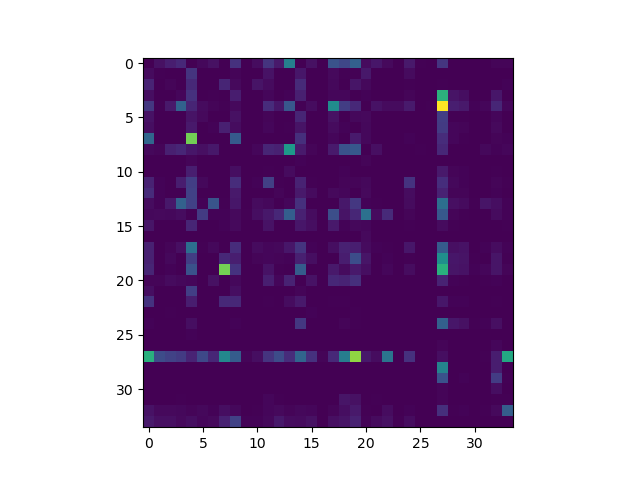

In [28]:
plt.imshow(trans_mat)

In [31]:
import pandas as pd

df = pd.DataFrame(trans_mat)
filepath = "transmat.xlsx"
df.to_excel(filepath, index=False)

## Looking at Eigen Decomposition

In [33]:
e,EV = np.linalg.eigh(trans_mat) 
# reverse since last eigenvectors are the ones we want
U = EV[::-1] 
# reverse since eigenvalues are in increasing order
S = np.sqrt(e)[::-1] 
print(S, U)

[333.47104822 175.3048383  170.45568659 119.55078318  99.75317968
  88.46198105  82.11114968  76.31563769  54.75154589  50.56902728
  39.88476509  33.61842924  28.34124309  22.92852115  20.79054356
  17.07577433   7.34699759   2.0485983           nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan] [[-8.46331208e-02 -3.26603756e-02 -5.34658298e-02  1.38050165e-01
  -1.16204258e-01 -5.88313647e-01  2.07080217e-01 -1.42823586e-01
   3.72505551e-02  5.90197400e-02 -4.46632623e-02  1.40396356e-01
  -3.86564071e-02  4.22603113e-03  2.09387246e-06  5.64085581e-04
   1.39794584e-02 -8.73489288e-03 -1.38403502e-03 -7.59666495e-03
  -9.26556659e-02  5.35106932e-03 -6.22583958e-02 -2.49664201e-01
   1.34384853e-01 -1.04322752e-01 -1.77711036e-01 -3.94430969e-01
  -3.91604979e-01 -1.69119618e-01 -1.82756710e-01 -7.38558917e-02
   2.20152000e-02 -7.9

/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


<IPython.core.display.Javascript object>


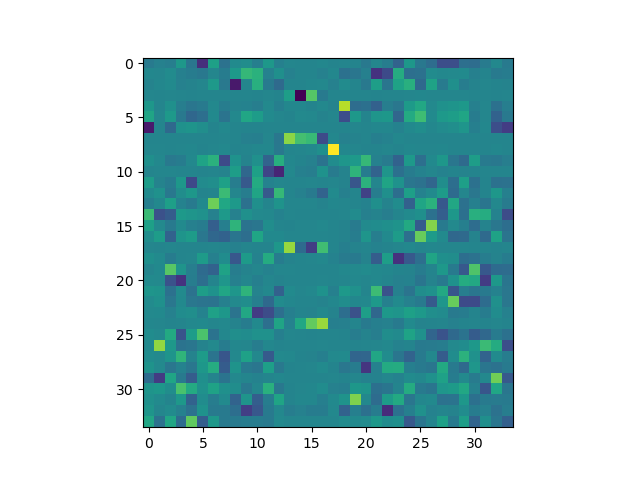

In [34]:
plt.imshow(U)

We see this is much more evenly distributed over the space.

Also the eigenvalues are only non-Nan for the first 15 - we can probably ditch some of the dimensionality.

In [36]:
# https://bic-berkeley.github.io/psych-214-fall-2016/printing_floating.html
np.set_printoptions(suppress=True)

In [37]:
print(U[0, :])

[-0.08463312 -0.03266038 -0.05346583  0.13805016 -0.11620426 -0.58831365
  0.20708022 -0.14282359  0.03725056  0.05901974 -0.04466326  0.14039636
 -0.03865641  0.00422603  0.00000209  0.00056409  0.01397946 -0.00873489
 -0.00138404 -0.00759666 -0.09265567  0.00535107 -0.0622584  -0.2496642
  0.13438485 -0.10432275 -0.17771104 -0.39443097 -0.39160498 -0.16911962
 -0.18275671 -0.07385589  0.0220152  -0.07949443]


In [38]:
U[0, :].sum()

-2.3346909060125265

In [39]:
U[:, 0].sum()

1.4348617126531118

In [40]:
norm_U = U / U[0, :]

In [41]:
norm_U

array([[      1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ,       1.        ,       1.        ,
              1.        ],
       [     -0.17852244,      -0.03346681,      -0.92025559,
             -0.27518992,       0.55312506,       0.16840308,
              0.03699238,       0.48187012,       3.9954745 ,
              6.43310507,      -7.50726397,      -0.226502  ,
             -1.88281052,      -6.69000031,

In [43]:
# Or using SVD - https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
u, s, vh = np.linalg.svd(trans_mat, full_matrices=True)

In [44]:
print(u, s, vh, end="\n\n")

[[-0.20527994  0.08771664  0.37330146  0.22686682 -0.29203422  0.15794685
   0.14444654 -0.11179447 -0.30996386 -0.01136243 -0.28287823  0.14816106
  -0.13102967  0.25459566  0.13125688 -0.28064849  0.20581404 -0.01518132
   0.078827    0.36011935  0.01324457 -0.12376365  0.13851037 -0.11483742
   0.09208076 -0.04689483 -0.02993777 -0.02904685 -0.0243715   0.01254849
  -0.00600506  0.00467327  0.0028308   0.00087552]
 [-0.03729236  0.00347658 -0.08543967  0.11387277 -0.0563996  -0.09318528
  -0.03931107  0.11133342  0.03019091  0.15205871  0.07188448  0.25858937
   0.11469552  0.07584492 -0.04824499  0.10027189 -0.02172129  0.10446654
   0.11397887  0.09470921  0.22298298 -0.64827507 -0.19309042  0.32992972
  -0.0975399   0.08979019  0.09295586 -0.19946708  0.27571417 -0.12401755
  -0.12236324 -0.04322152  0.03813461  0.00174416]
 [-0.06480137  0.04669589 -0.11639685  0.0118517  -0.10480214 -0.01498245
   0.0059423   0.08809515  0.05237348  0.05276312  0.30347655  0.0667383
   0.016694

In [45]:
print(u.shape, s.shape, vh.shape)

(34, 34) (34,) (34, 34)


In [46]:
a_onehot = np.zeros(shape=(34, 1))
a_onehot[0] = 1

In [49]:
np.dot(vh, a_onehot)

array([[-0.26569531],
       [ 0.25976217],
       [-0.21936483],
       [ 0.08381332],
       [ 0.23376504],
       [-0.21587562],
       [ 0.29498814],
       [-0.0713091 ],
       [ 0.077623  ],
       [-0.11080931],
       [ 0.40910196],
       [-0.40178786],
       [ 0.13773107],
       [-0.22628951],
       [ 0.33077246],
       [-0.02200888],
       [-0.2258464 ],
       [ 0.10417195],
       [ 0.02925374],
       [ 0.10262621],
       [-0.0144605 ],
       [-0.02495492],
       [-0.05821223],
       [-0.04705626],
       [-0.02804388],
       [-0.03105593],
       [-0.03402812],
       [-0.05569461],
       [-0.00443041],
       [-0.00010443],
       [-0.01478604],
       [-0.01310845],
       [-0.01225555],
       [-0.00263732]])